In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Dependencies
from pymongo import MongoClient
import os
import pandas as pd
import numpy as np
import missingno
from datetime import datetime

from urls_list import * #where all urls and paths are saved
from config import *

### Check DB for any duplicate rental IDs

In [28]:
def checkSanity(collection, pk):
    client = MongoClient(db_connection_string)
    
    records = list(client.ETLInsights[collection].find({}, {pk:1, '_id':0}))
    total_unique_records = len(set(post[pk] for post in records))
    total_records = client.ETLInsights[collection].count_documents({})
    print(f"Total records: {total_records}")
    print(f"Total uniique records: {total_unique_records}")
    if(total_unique_records == total_records):
        print(f"{collection} is sane")
    else:
        print(f"Sanity check failed for {collection}")
    client.close()

In [29]:
checkSanity("HistoricRental", "id")

Total records: 3315
Total uniique records: 3315
HistoricRental is sane


In [30]:
checkSanity("CurrentRental", "id")

Total records: 2938
Total uniique records: 2938
CurrentRental is sane


### Insert Kijiji Data to the HistoricRental DB

In [34]:
Kijiji = pd.read_csv(os.path.join('..', 'Data', 'kijiji_rental_final.csv'))

In [80]:
# client = MongoClient(db_connection_string)
# client.ETLInsights.HistoricRental.insert_many(Kijiji.T.to_dict().values())
# client.close()

In [38]:
checkSanity("HistoricRental", "id")

Total records: 3837
Total uniique records: 3837
HistoricRental is sane


### Insert Community assets Data in DB

In [76]:
Community_Assets = pd.read_csv(os.path.join('..', 'Data', 'community_assets_with_cooridnates.csv'))

(array([], dtype=int64),)

(array([], dtype=int64),)

,service_name,service_name_2
0,Child and Family Services Review Board,NaN
1,Custody Review Board,NaN
2,Social Justice Tribunals Ontario,NaN
3,Anita Ekstein Holocaust Resource Library,NaN
4,Alexandra Park Community Centre,NaN
...,...,...
2675,Prosper Canada,NaN
2676,Al Green Resource Centre,NaN
2677,CARE Centre for Internationally Educated Nurses,NaN
2678,Canadian Safe School Network,NaN


(array([], dtype=int64),)

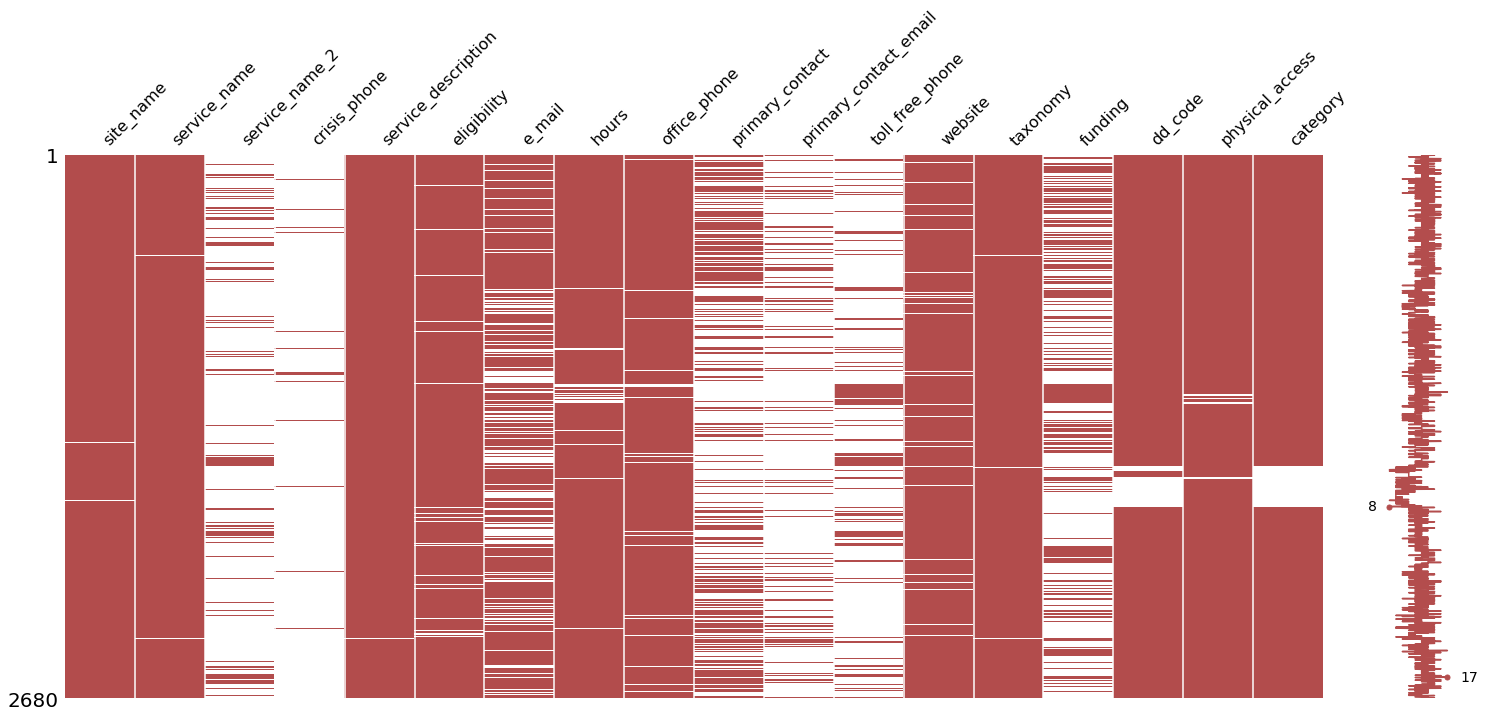

In [77]:
np.where(Community_Assets['id']!=Community_Assets['id.1'])
np.where(Community_Assets['address']!=Community_Assets['address.1'])
Community_Assets[['service_name','service_name_2']] 

#Cleaunp
Community_Assets.drop(['id', 'id.1', 'address.1'], axis=1, inplace=True) #id is not in order; 'id.1', 'address.1' are repeated
Community_Assets.reset_index(inplace=True)
Community_Assets.rename(columns={"index":"id"}, inplace=True)


#Check for nan
missingdata_cols = Community_Assets.columns[Community_Assets.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(Community_Assets[missingdata_cols], color=(0.7,0.3,0.3))
np.where(Community_Assets.duplicated()) #No rows are duplicated

In [79]:
# client = MongoClient(db_connection_string)
# client.ETLInsights.CommunityAssets.insert_many(Community_Assets.T.to_dict().values())
# client.close()

In [81]:
checkSanity("CommunityAssets", "id")

Total records: 2680
Total uniique records: 2680
CommunityAssets is sane


### Insert Crime Data in DB

In [120]:
#Crime is from 2019 Jan 01 onwards
Crime = pd.read_csv(os.path.join('..', 'Data', 'Crime.csv'))
np.where(Crime.duplicated()) #No rows are duplicated
#CrimeLastSixMonths is from 2019 June 01 onwards
CrimeLastSixMonths = Crime[Crime['occurrencedate'].map(lambda x: datetime.strptime(x, "%Y-%m-%d")>=datetime.strptime('2019-06-01', "%Y-%m-%d"))].copy()   
CrimeLastSixMonths.drop(['id'], axis=1, inplace=True)
CrimeLastSixMonths.reset_index(drop=True, inplace=True)
CrimeLastSixMonths.reset_index(inplace=True)
CrimeLastSixMonths.rename(columns={"index":"id"}, inplace=True)

(array([], dtype=int64),)

In [125]:
# client = MongoClient(db_connection_string)
# client.ETLInsights.Crime.insert_many(Crime.T.to_dict().values())
# client.ETLInsights.CrimeLastSixMonths.insert_many(CrimeLastSixMonths.T.to_dict().values())
# client.close()

In [6]:
#Crime is from 2019 Jan 01 onwards
Crime = pd.read_csv(os.path.join('..', 'Data', 'Crime.csv'))
np.where(Crime.duplicated()) #No rows are duplicated
#CrimeLastSixMonths is from 2019 June 01 onwards
CrimeLastMonth = Crime[Crime['occurrencedate'].map(lambda x: datetime.strptime(x, "%Y-%m-%d")>=datetime.strptime('2019-12-01', "%Y-%m-%d"))].copy()   
CrimeLastMonth.drop(['id'], axis=1, inplace=True)
CrimeLastMonth.reset_index(drop=True, inplace=True)
CrimeLastMonth.reset_index(inplace=True)
CrimeLastMonth.rename(columns={"index":"id"}, inplace=True)

(array([], dtype=int64),)

In [8]:
# client = MongoClient(db_connection_string)
# client.ETLInsights.CrimeLastMonth.insert_many(CrimeLastMonth.T.to_dict().values())
# client.close()

In [126]:
checkSanity("Crime", "id")

Total records: 37752
Total uniique records: 37752
Crime is sane


In [127]:
checkSanity("CrimeLastSixMonths", "id")

Total records: 22949
Total uniique records: 22949
CrimeLastSixMonths is sane


### Insert Income Data in DB

In [128]:
FSA_Avg_Income = pd.read_csv(os.path.join('..', 'Data', 'FSA_Avg_Income.csv'))

In [136]:
# client = MongoClient(db_connection_string)
# client.ETLInsights.FSAIncome.insert_many(FSA_Avg_Income.T.to_dict().values())
# client.close()

In [137]:
checkSanity("FSAIncome", "FSA")

Total records: 197
Total uniique records: 197
FSAIncome is sane


## Merge Income and Avg Age CSVs together

In [31]:
FSA_Avg_Income = pd.read_csv(os.path.join('..', 'Data', 'Toronto_FSA_Final.csv'))

In [32]:
FSA_Avg_Income = FSA_Avg_Income[FSA_Avg_Income['FSA'].str.startswith('M')]

In [ ]:
FSA_Avg_Age = pd.read_csv(os.path.join('..', 'Data', 'FSA_Avg_age.csv'))

In [ ]:
set(FSA_Avg_Income['FSA']).difference(set(FSA_Avg_Age['FSA']))
set(FSA_Avg_Age['FSA']).difference(set(FSA_Avg_Income['FSA']))

## Do a left merge FSA_Avg_Income with FSA_Avg_Age

In [ ]:
FSA_Income_Age = FSA_Avg_Income.merge(FSA_Avg_Age, on="FSA", how="left")

In [ ]:
FSA_Income_Age.iloc[np.where(FSA_Income_Age.isna())[0]]

## NaN fixing in the DB

In [38]:
client = MongoClient(db_connection_string)

In [39]:
coll_names = client.ETLInsights.list_collection_names()

In [40]:
# for col in coll_names:
#     list_of_attributes = list(client.ETLInsights[col].find_one().keys())
#     #print(list_of_attributes)
#     for item in list_of_attributes:
#         query = {item: np.NAN}
#         newvalues = { "$set": { item: "" } }
#         client.ETLInsights[col].update_many(query, newvalues)

In [10]:
# for col in coll_names:
#     list_of_attributes = list(client.ETLInsights[col].find_one().keys())
#     #print(list_of_attributes)
#     for item in list_of_attributes:
#         query = {item: np.NAN}
#         list(client.ETLInsights[col].find(query))

In [12]:
# list_of_attributes = list(client.ETLInsights.CrimeLastMonth.find_one().keys())
# #print(list_of_attributes)
# for item in list_of_attributes:
#     query = {item: np.NAN}
#     newvalues = { "$set": { item: "" } }
#     client.ETLInsights.CrimeLastMonth.update_many(query, newvalues)